# M3 exam: Predicting sentiment of reviews using NLP and deep learning
Michael Dybdahl

29/11/2019



# Description of data acquisition

I found the dataset [Women's E-Commerce Clothing Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) from kaggle which contain 23k reviews on women clothes bought online. This is real commercial data which has been anonymized, and references to the company in the review text and body have been replaced with “retailer”.

The dataset contain 11 variables: 
* **X1**: ID of the review
* **Clothing ID:** Unique ID of the product
* **Age:** Age of the reviewer
* **Title:** Title of the review
* **Review:** Text review
* **Rating:** Product rating by reviewer
* **Recommended IND:** Whether the product is recommended or not by the reviewer
* **Positive Feedback Count:** Number of positive feedback on the review
* **Division Name:** Name of the division product is in
* **Department Name:** Name of the department product is in
* **Class Name:** Type of product

# Problem statement

**How can the sentiment of a review be predicted using NLP, deep learning and non-neural baseline models?**

Having all these reviews from customers who have bought the clothes online, it would be interesting to see if I can build some models that can predict whether a review has a negative or positive sentiment, especially the negative reviews can be interestering to look at - to see what the firm can improve.

I will use NLP to make a tidy format of the data and find the sentiment of the reviews.

# Load packages
I start by loading the required packages.

In [110]:
library(keras)
library(dplyr)
library(ggplot2)
library(purrr)
library(tidyverse)
library(magrittr)
library(tidytext)
library(SnowballC)
library(caret)
library(rsample)
library(glmnet)
library(doMC)
library(broom)
library(yardstick)

# Load data

Here I load the data with "read_csv" as usual.

The data where loaded in the kaggle data folder and can be downloaded here: https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

In [112]:
data <- read_csv("../input/Womens%20Clothing%20E-Commerce%20Reviews.csv")

Parsed with column specification:
cols(
  X1 = col_double(),
  `Clothing ID` = col_double(),
  Age = col_double(),
  Title = col_character(),
  `Review Text` = col_character(),
  Rating = col_double(),
  `Recommended IND` = col_double(),
  `Positive Feedback Count` = col_double(),
  `Division Name` = col_character(),
  `Department Name` = col_character(),
  `Class Name` = col_character()
)



# Preprocessing data

I will start by doing some simpel processing by renaming variables and remove observations with missing values.

**Renaming variables:**

Many of the variables have these "´´" because of the spaces in their names. For my own sake, I will rename the variables so I get rid of these (imo) annoying symbols. 

In [113]:
data <- data %>%
  rename(
    ClothingID = `Clothing ID`,
    Review = `Review Text`,
    Recommended = `Recommended IND`,
    FeedbackCount =  `Positive Feedback Count`,
    Division =  `Division Name`,
    Department =  `Department Name`,
    Category =  `Class Name`
  )

In [114]:
glimpse(data)

Observations: 23,486
Variables: 11
$ X1            <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1…
$ ClothingID    <dbl> 767, 1080, 1077, 1049, 847, 1080, 858, 858, 1077, 1077,…
$ Age           <dbl> 33, 34, 60, 50, 47, 49, 39, 39, 24, 34, 53, 39, 53, 44,…
$ Title         <chr> NA, NA, "Some major design flaws", "My favorite buy!", …
$ Review        <chr> "Absolutely wonderful - silky and sexy and comfortable"…
$ Rating        <dbl> 4, 5, 3, 5, 5, 2, 5, 4, 5, 5, 3, 5, 5, 5, 3, 4, 3, 5, 5…
$ Recommended   <dbl> 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1…
$ FeedbackCount <dbl> 0, 4, 0, 0, 6, 4, 1, 4, 0, 0, 14, 2, 2, 0, 1, 3, 2, 0, …
$ Division      <chr> "Initmates", "General", "General", "General Petite", "G…
$ Department    <chr> "Intimate", "Dresses", "Dresses", "Bottoms", "Tops", "D…
$ Category      <chr> "Intimates", "Dresses", "Dresses", "Pants", "Blouses", …


**Removing observations with missing (NA) values:**

I have a pretty big dataset with 23.486 observations and therefor I will see if I can remove all observations with missing values in the 11 variables. 


In [115]:
sum(is.na(data$Review))

[1] 845

In [116]:
sum(is.na(data))

[1] 4697

So 845 of the observations have no Review and 4697 observations have missing values in one or more of the variables.

I consider the dataset to be big enough even removing the 4697 observations and will therefor drop all the NA values.

In [117]:
data <- data %>%
  drop_na()

In [118]:
sum(is.na(data))

[1] 0

In [119]:
glimpse(data)

Observations: 19,662
Variables: 11
$ X1            <dbl> 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18,…
$ ClothingID    <dbl> 1077, 1049, 847, 1080, 858, 858, 1077, 1077, 1077, 1095…
$ Age           <dbl> 60, 50, 47, 49, 39, 39, 24, 34, 53, 53, 44, 50, 47, 34,…
$ Title         <chr> "Some major design flaws", "My favorite buy!", "Flatter…
$ Review        <chr> "I had such high hopes for this dress and really wanted…
$ Rating        <dbl> 3, 5, 5, 2, 5, 4, 5, 5, 3, 5, 5, 3, 4, 3, 5, 5, 5, 4, 4…
$ Recommended   <dbl> 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ FeedbackCount <dbl> 0, 0, 6, 4, 1, 4, 0, 0, 14, 2, 0, 1, 3, 2, 0, 0, 0, 2, …
$ Division      <chr> "General", "General Petite", "General", "General", "Gen…
$ Department    <chr> "Dresses", "Bottoms", "Tops", "Dresses", "Tops", "Tops"…
$ Category      <chr> "Dresses", "Pants", "Blouses", "Dresses", "Knits", "Kni…


So now the names are fine, I've dropped the NA values and the variables are formatted correct. 

Now time for some EDA.

# 1. Exploratory data analysis (EDA)

I this section I will start by doing some simpel exploratory data anlysis, to see a bit deeper into the dataset.****

**How many does not have a positive feedback count?**

I just wonna start by seeing how many of the reviews have 0 i Feedback count, which means that no one have given the review a positiv feedback.

In [120]:
sum(data$FeedbackCount == 0)

[1] 8930

So almost half of the reviews does not have any positiv feedback count. That's probably to be expected because many people will just look at the feedback without giving it a "like"/positiv feedback. 

**Rating - distribution:**

Here I will make a histogram to check how the rating are distributed among the five ratings (1-5). 

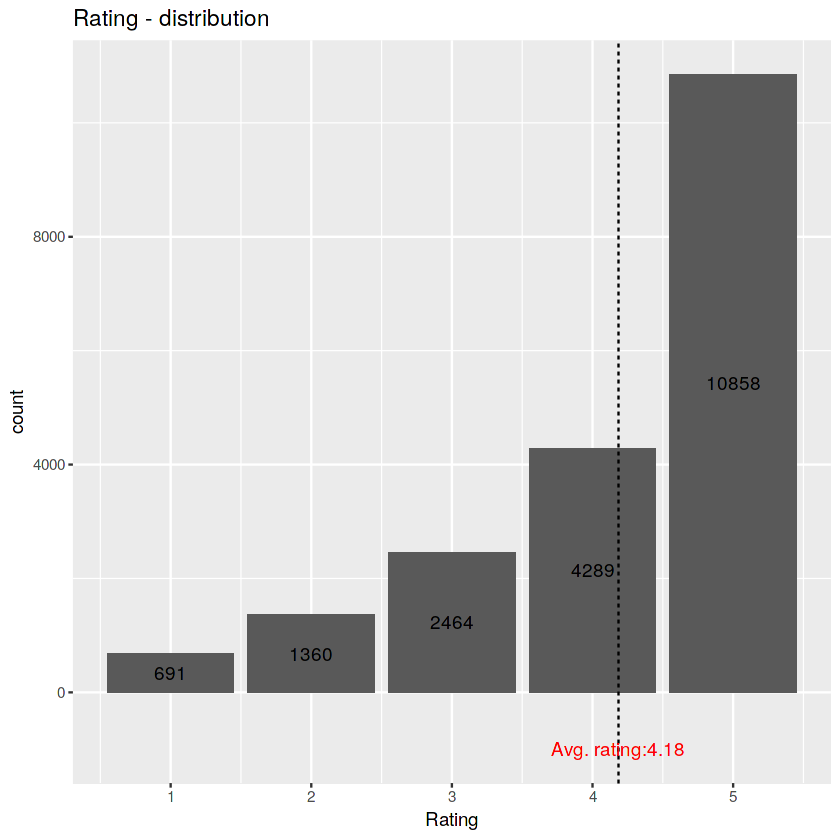

In [121]:
ggplot(data,aes(Rating))+ #add rating as the x value
geom_bar()+ # I make a histogram, cause I just want to see the distribution (counts)
labs(title = "Rating - distribution", x = "Rating")+
geom_vline(xintercept = mean(data$Rating), linetype = 2)+
geom_text(aes(label=..count..),stat="count",position=position_stack(0.5))+
annotate("text", x = mean(data$Rating), y = -1000, # I add where I want the Avg rating to be in the plot
                 label = paste0("Avg. rating:", round(mean(data$Rating), digits =2)),color="red") # Create the label with the text

As you can see, then the highest rating (5) accounts for over half of the distribution, and the 2nd most counted rating is rating 4. 

We can also see by the vline in the plot, that the average rating is 4,18, which is pretty high for a scale from 1 to 5. 

**Age - distribution:**

Let us see how the age for the reviewers are distributed, again using a histogram. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



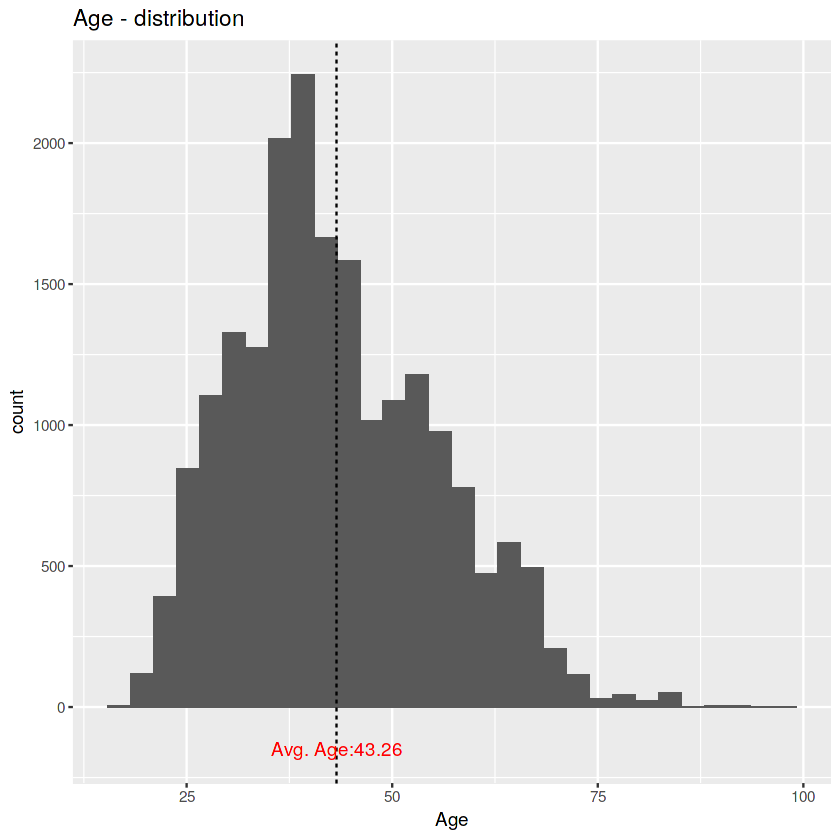

In [122]:
ggplot(data,aes(Age))+ #add Age as the x value
geom_histogram()+ # I make a histogram, cause I just want to see the distribution (counts)
labs(title = "Age - distribution", x = "Age")+
geom_vline(xintercept = mean(data$Age), linetype = 2)+ # I add the line that represents the mean age
annotate("text", x = mean(data$Age), y = -150, # I add where I want the Avg Age to be in the plot
                 label = paste0("Avg. Age:", round(mean(data$Age), digits =2)), color="red") # Create the label with the text

We can see that the average age is 43,2 year and the distribution is pretty normal distributed. This make some sence, because probable the young girls does not think about reviewing their purchases online, and perhaps not many older women shop online.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



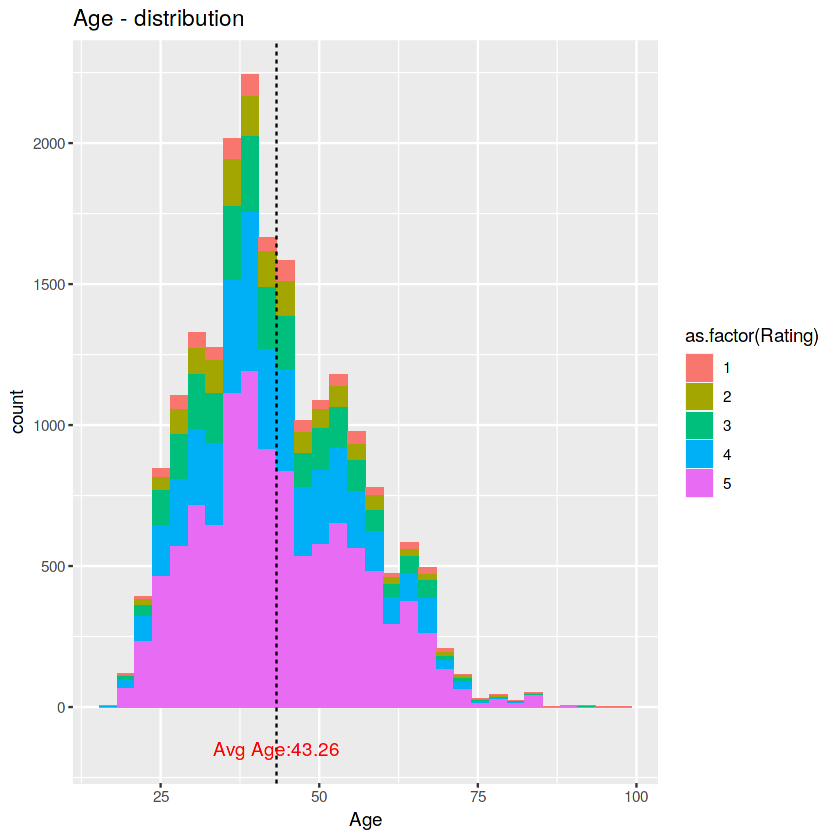

In [123]:
ggplot(data,aes(Age, fill = as.factor(Rating)))+ # I add so the Rating is filling the x values. 
geom_histogram()+
labs(title = "Age - distribution", x = "Age")+
geom_vline(xintercept = mean(data$Age), linetype = 2)+ 
annotate("text", x = mean(data$Age), y = -150, 
                 label = paste0("Avg Age:", round(mean(data$Age), digits =2)), color="red") 

Will not much to see about the age and ratings, because it seems that the ratings are even represented in the different ages. Maybe the women in the 30-40 years, seems to have more 1-3 ratings, but thats not totally clear.

**Checking the three divisions:**

The "Division" variable contain three divisions and therefor I want to see if there are some clear differents between these. 

In [124]:
data %>%
    group_by(Division) %>%
    summarize(mean_rating = mean(Rating))

Division,mean_rating
<chr>,<dbl>
General,4.166924
General Petite,4.196666
Initmates,4.263115


No differents in the average rating for the three divisions, where it is around 4.2 for all (pretty high).

In [125]:
count(data, data$Division)

data$Division,n
<chr>,<int>
General,11664
General Petite,6778
Initmates,1220


Over half of the reviews are from the General division, but also a huge amount from "General Petite" - so apparantly many short women (petite = women under 162cm). 



> # 2. NLP

## 2.1. Bag-of-words

To train a model for predicting the sentiment of a review, I need to create a BoW (bag-of-words).


First I tokenize the Titles into words by using "unnest_tokens". 

In [127]:
data_tidy <- data %>% 
  select(X1, Review) %>% # I select X1 (review ID) and the Title
  unnest_tokens(output = word, input = Review)

Now I want to anti join stop words from the "stop_words" lexicon. 

In [128]:
data_tidy %<>% # I use "%<>%" which both assigns and pipe - instead of first assigning and then piping. 
  anti_join(stop_words, by = "word") # I use anti_join instead of filter, because it should be a bit faster.

In [129]:
data_tidy %>%
  count(word, sort = TRUE) %>% # Count "word". "sort = TRUE" means that it will sort the words in descending order of number words.
  head(20)

word,n
<chr>,<int>
dress,9345
size,7866
love,7726
fit,6600
top,6548
wear,5722
fabric,4309
color,4111
perfect,3340


We can see that "dress" is the most frequent word and in the top20 and most of the words are positive words, which makes sence with the high ratings that we saw in the EDA. 

I also remove symbols etc and remove all non-Alphanumeric characters.

In [130]:
data_tidy %<>%
  mutate(word = trimws(gsub("[^\\s]*[0-9][^\\s]*", "", word, perl = T))) %>%
  filter(str_length(word) > 1) # this filter out the words that are blank.

In [131]:
data_tidy %<>%
  mutate(word = word %>% str_remove_all("[^[:alnum:]]") ) %>% # alnum = Alphanumeric characters. 
  filter(str_length(word) > 1) # filter out words with 1 character.

I also do some stemming on the BoW. 

This actually gave me **1-2%** more in validation accuracy for my models compared to the first models I trained, where I did not stemmed.

In [132]:
data_tidy %<>%
    mutate(word = wordStem(word))

## 2.2. Sentiment analysis

With the BoW, I will use the sentiment lexicons to add sentiment for each review.

I actually wanted to use "afinn" lexicon, but I could get this working and only "bing" worked. So this became a easy choice.

**Bing:** gives a negative/positive label for each word.

I faced a problem with joining the sentiments with bing, because it adds the sentiment "positive/negative" to each word. This can't really work when I join the sentiments with the data by "X1" (review ID), because a review can of course contain both words with positive and negative sentiments. 

To help with this, I found probably a bit alternative approach where I add a "value" of the words.

n.x = word count per review (X1)
n.y = total word count per review
Positive words: value = n.x / n.y
Negative words: value = -n.x / n.y (gives a negative weight)

Then I can afterwards group the data by "X1" and summarise by the total value. So fx if a review have more negative words, the total value will become negative when summarising.

Then:
Total value > 0 = Positive
Total value <= 0 = Negative

In [134]:
word_totals <- data_tidy %>% 
group_by(X1) %>% # I group all the words by "X1" (review ID)
count() # I count so I get number of words in each review = becomes "n.y" when joining below.

In [135]:
data_sent <- data_tidy %>%
    inner_join(get_sentiments("bing")) %>%
    group_by(X1) %>%
    count(sentiment) %>%
    inner_join(word_totals, by = "X1") %>%
    mutate(value = ifelse(sentiment == 'positive', n.x/n.y, -n.x/n.y))

Joining, by = "word"



In [136]:
data_sent <- data_sent %>%
    group_by(X1) %>%
    summarise(total_value = sum(value)) %>%
    inner_join(data, by = "X1")

In [137]:
data_sent <- data_sent %>%
    mutate(Sentiment = ifelse(total_value>0, "Positive", "Negative"))

In [138]:
count(data_sent, data_sent$Sentiment)

data_sent$Sentiment,n
<chr>,<int>
Negative,4123
Positive,14452


By counting the two Sentiment outputs, we can see that there are 4123 Negative and 14452 Positive. This seems much realistic when thinking on the histogram from the EDA. 

I only have 18.575 observations now, where before tokenizing, I had 19.662. This is probably because I lost some reviews duing the tokenizing, for example reviews containing only stopwords or non-Alphanumeric characters.

**Creating a sentiment label.**

I need a binary 0 or 1 variable for the model training, and therefor I create a new variable, "label". 

label:
1 = Positive
0 = Negative

In [139]:
data_sent <- data_sent %>%
    mutate(label = ifelse(Sentiment == 'Positive', 1, 0))

# 3. Deep learning models

Having the dataset with sentiments ready, I can now begin to create some deep learning models.

## 3.1. Splitting up data

First I start by splitting up the data_sent into a training and test using, using a 75/25 split.

In [ ]:
set.seed(1337)
index <- createDataPartition(y = data_sent$label, p = 0.75, list = FALSE)
training <- data_sent[index,] 
test <- data_sent[-index,] 

## 3.2. Preprocessing

After having splitted up the data, I need to transform the reviews into numeric values (sequences), where I will use keras for all this preprocessing. 

First I set some parameters, "maxlen" and "max_features", which I use for preprocessing, and I also set the "batch_size" and "epochs", which I am going to use training the models. 

This makes it easier to adjust the parameters from here instead of doing it manually in several steps.

In [ ]:
# Set parameters:
maxlen <- 100 # I set a max length of the sequences to 100.
max_features <- 10000 # I only consider the 10.000 most common words.
batch_size <- 128 # I set batch size to 128 (tested all from 8 to 512 batch sizes)
epochs <- 10 # Here I also tested epochs from 2-50, where 10 seemed to give the best results.

I set the tokenizer with the number of words to the 10.000 most common words.

In [ ]:
tokenizer <- text_tokenizer(num_words = max_features)

Now I tokenize the reviews for both the training and test set. 

In [ ]:
tokenizer_train <- tokenizer %>%
    fit_text_tokenizer(training$Review)

tokenizer_test <- tokenizer %>%
    fit_text_tokenizer(test$Review)

I need the reviews in sequences and also padding them into a maxlen of 100.

In [ ]:
x_train <- tokenizer_train %>% # setting the x values for the training set.
            texts_to_sequences(training$Review) %>%
            pad_sequences(maxlen=maxlen)

y_train <- training$label # setting the v values (the negative/positive labels I want to predict)

x_test <- tokenizer_test %>% # setting the x values for the test set.
            texts_to_sequences(test$Review) %>%
            pad_sequences(maxlen=maxlen)

y_test <- test$label # setting the v values (the negative/positive labels I want to predict)

In [ ]:
dim(x_train) # testing that I have the same length for both x and y values
length(y_train)

## 3.3. Basic feed-forward ANN

I first want to make a basic feed-forward ANN, just to see how that performs vs. the RNN models.

### 3.3.1. Setting the architecture and tuning**

Here I set the architecture and tuning for this baseline feed-forward ANN model. 

In [ ]:
set.seed(1337)
model_ANN <- keras_model_sequential() %>%
  layer_dense(units = 16, activation = "relu", input_shape = c(100)) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid") %>% # output layer -> 1 unit and sigmoid cause of binary problem.
compile( 
  loss = "binary_crossentropy", # I use this because I have a binary classification problem. 
  optimizer = "rmsprop", # Good general optimizer + 'adam' and 'sgd' gave bad results. 
  metrics = "accuracy"
)

In [ ]:
summary(model_ANN)

### 3.3.2. Fitting the model

In [ ]:
set.seed(1337)
hist_ANN <- model_ANN %>%
  fit(
    x_train,
    y_train,
    batch_size = batch_size, # Predefined parameter
    epochs = epochs, # Predefined parameter
  validation_split=0.2 # Higher split caused overfitting and smaller value = worse results.
  )

# I tried for fun to weight the classes because of the inbalanced classes (4k vs 14k sentiment) - didn't worked at all.   
# class_weight = list("0"=3.5,"1"=1)

### 3.3.3. Evaluating the model

`geom_smooth()` using formula 'y ~ x'



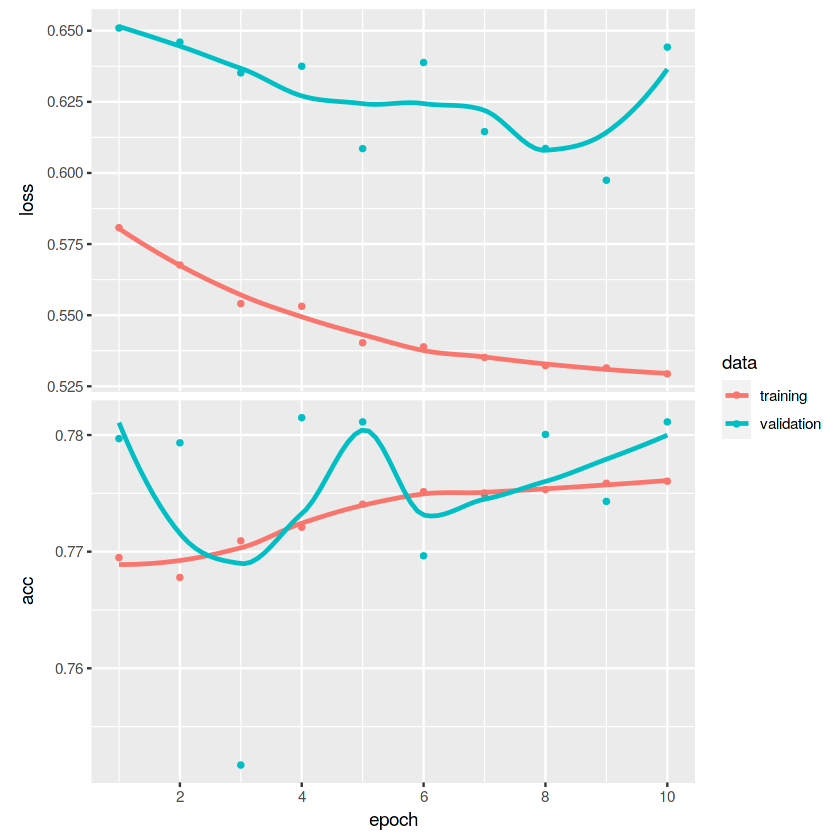

In [141]:
plot(hist_ANN)

In [142]:
hist_ANN$metrics$val_acc

[1] 0.7796914 0.7793326 0.7517043 0.7814855 0.7811267 0.7696448 0.7750269
 [8] 0.7800502 0.7743093 0.7811267

In [143]:
results_ANN <- model_ANN %>% evaluate(x_test, y_test)
results_ANN

$loss
[1] 0.6385758

$acc
[1] 0.7751454

Well the models accuracy seems to be "alright" with 77,5% accuracy, although it overfits after 4-5 epochs.

Looking at the validation accuracy for each 10 epochs, it seems a bit weird that most of the validation accuracys are round 77%, which is also the part of positive reviews based on the sentiments (14452 / (4123+14452) = 77,8%). 

So perhaps the model just predict every positive review correct, but not really the negative reviews. Let us look a bit into this by making a confusion matrix.

In [144]:
pred_model_ANN <- predict_classes(model_ANN, x_test)
confusionMatrix(table(pred_model_ANN, y_test))

Confusion Matrix and Statistics

              y_test
pred_model_ANN    0    1
             0    7   35
             1 1009 3592
                                          
               Accuracy : 0.7751          
                 95% CI : (0.7629, 0.7871)
    No Information Rate : 0.7812          
    P-Value [Acc > NIR] : 0.8441          
                                          
                  Kappa : -0.0042         
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.006890        
            Specificity : 0.990350        
         Pos Pred Value : 0.166667        
         Neg Pred Value : 0.780700        
             Prevalence : 0.218824        
         Detection Rate : 0.001508        
   Detection Prevalence : 0.009046        
      Balanced Accuracy : 0.498620        
                                          
       'Positive' Class : 0               
           

* So yes, the model predict 99,03% positive reviews correct and only 0,6% negative reviews correct.

This was also only a simpel baseline FF model, so probably I could't expect more from it.

## 3.4. Simple RNN model

### 3.4.1. Setting the architecture and tuning

Now I want to run a RNN model, where I add an embedding and simple rnn layer. 

In [ ]:
set.seed(1337)
model <- keras_model_sequential() %>%
  layer_embedding(input_dim = max_features, output_dim = 100, input_length=maxlen) %>% # input_dim 10000 because the vocabulary (max features), which I sat to 10.000.
  layer_simple_rnn(units = 32, activation = "tanh", dropout = 0.25) %>% # = the layer on top.
  layer_dense(units = 1, activation = "sigmoid")  %>% # dense layer for the review sentiment predicition. 
compile( 
  loss = "binary_crossentropy", # I use "binary_crossentropy" because I have abinary classification problem and the output of your network is a probability.
  optimizer = "rmsprop", # I used "adam" as optimizer, which ran better than "rmsprop" - not sure why. 
  metrics = "accuracy" # Well I wanted to use another metric because of the inbalanced classes (fx Kappa), but did not figure out one.
)



### 3.4.2. Fitting the model

In [ ]:
set.seed(1337)
hist <- model %>%
  fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
  validation_split=0.2
  )

### 3.4.3. Evaluating the model

`geom_smooth()` using formula 'y ~ x'



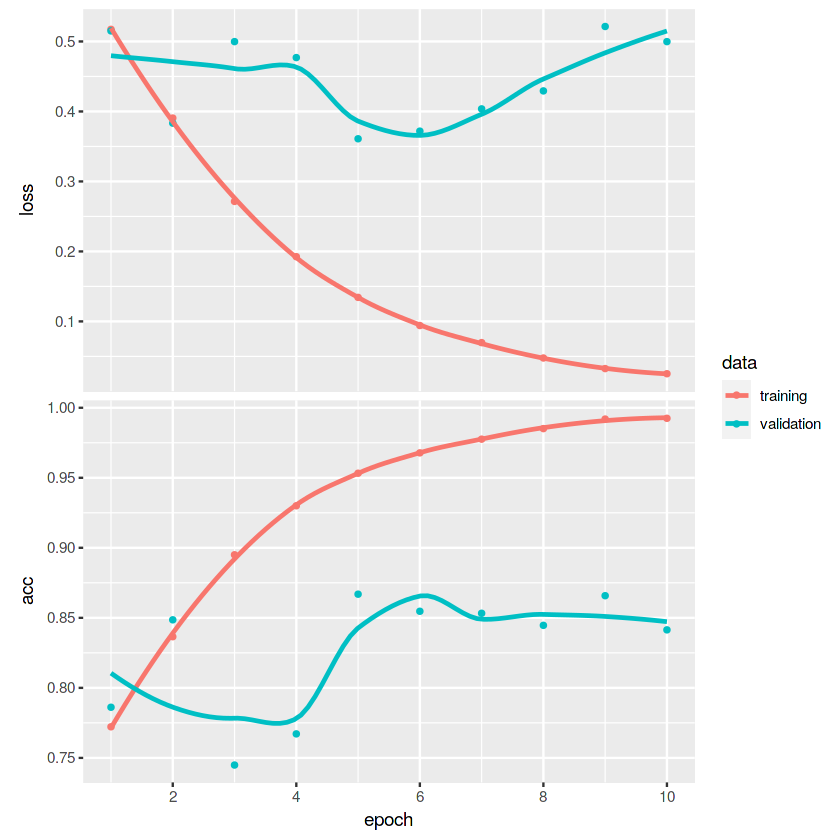

In [147]:
plot(hist)

![](http://)Look like it overfits after 5 epochs..

In [148]:
hist$metrics$val_acc

[1] 0.7861500 0.8485827 0.7448870 0.7671331 0.8668820 0.8546824 0.8532472
 [8] 0.8446358 0.8658055 0.8414065

Well the model gives some more varying results, where the validation accuracy is around 74-86,6% - 86,6% tops at 5th epoch. 

In [62]:
results <- model %>% evaluate(x_test, y_test)
results

$loss
[1] 0.4569945

$acc
[1] 0.8492354

An significantly better accuracy with 84,92% compared to 77,5% from the basic FF model

Let us see if it still predicts only the positive reviews.

In [63]:
pred_model <- predict_classes(model, x_test)
confusionMatrix(table(pred_model, y_test)) 

Confusion Matrix and Statistics

          y_test
pred_model    0    1
         0  681  365
         1  335 3262
                                          
               Accuracy : 0.8492          
                 95% CI : (0.8386, 0.8594)
    No Information Rate : 0.7812          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.5637          
                                          
 Mcnemar's Test P-Value : 0.273           
                                          
            Sensitivity : 0.6703          
            Specificity : 0.8994          
         Pos Pred Value : 0.6511          
         Neg Pred Value : 0.9069          
             Prevalence : 0.2188          
         Detection Rate : 0.1467          
   Detection Prevalence : 0.2253          
      Balanced Accuracy : 0.7848          
                                          
       'Positive' Class : 0               
                           

Well what a improvement.

67,03% of the negative reviews are predicted true and 89,94% of the positive reviews. 

## 3.5. LSTM model

### 3.5.1. Setting the architecture and tuning

In [65]:
model_lstm <- keras_model_sequential() %>%
  layer_embedding(input_dim = 10000, output_dim = 32) %>%
  layer_lstm(units = 500, dropout = 0.25, recurrent_dropout = 0.25, return_sequences = FALSE) %>% # droput added to prevent overfitting -> recurrent for the output
  layer_dense(units = 1, activation = "sigmoid") %>% 
compile( 
  loss = "binary_crossentropy", # I use "binary_crossentropy" because I have abinary classification problem and the output of your network is a probability.
  optimizer = "rmsprop", # I used "adam" as optimizer, which ran better than "rmsprop" - not sure why. 
  metrics = "accuracy" # I use accuracy as metric because the response variable (TRUE/FAKE tweets) is balanced (8000 true vs. 7348 fake).
)

### 3.5.2. Fitting the model

In [70]:
hist_lstm <- model_lstm %>%
  fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = 20, # The val_acc was still raising at 10 epochs, and therefor I chose 20 epochs with a better result.
  validation_split=0.2
  )

### 3.5.3. Evaluating the model

`geom_smooth()` using formula 'y ~ x'



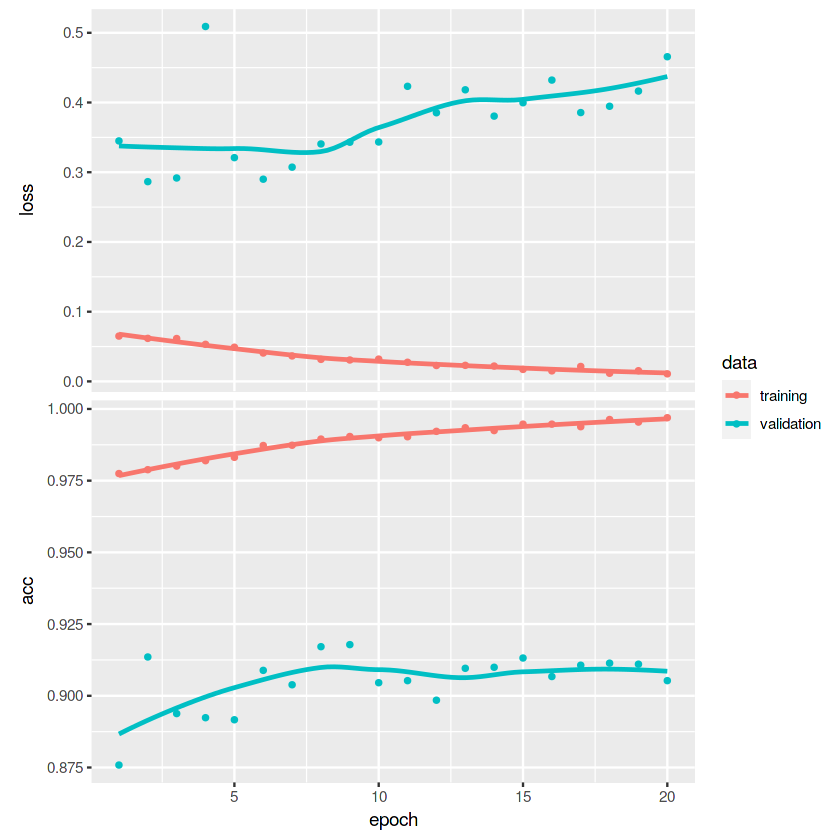

In [71]:
plot(hist_lstm)

Wow, what a improvement from the basic RNN model. 

In [72]:
results_lstm <- model_lstm %>% evaluate(x_test, y_test)
results_lstm

$loss
[1] 0.4490641

$acc
[1] 0.9093258

Accuracy improved with 6%, nice..

In [73]:
hist_lstm$metrics$val_acc

[1] 0.8758522 0.9135271 0.8937926 0.8923573 0.8916398 0.9088626 0.9038392
 [8] 0.9171152 0.9178328 0.9045569 0.9052745 0.8984571 0.9095802 0.9099390
[15] 0.9131683 0.9067097 0.9106566 0.9113742 0.9110155 0.9052745

Seems that the model is beginning to overfit at 9 epochs.

In [74]:
pred_lstm <- predict_classes(model_lstm, x_test)
confusionMatrix(table(pred_lstm, y_test)) 

Confusion Matrix and Statistics

         y_test
pred_lstm    0    1
        0  700  105
        1  316 3522
                                          
               Accuracy : 0.9093          
                 95% CI : (0.9007, 0.9174)
    No Information Rate : 0.7812          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7134          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6890          
            Specificity : 0.9711          
         Pos Pred Value : 0.8696          
         Neg Pred Value : 0.9177          
             Prevalence : 0.2188          
         Detection Rate : 0.1508          
   Detection Prevalence : 0.1734          
      Balanced Accuracy : 0.8300          
                                          
       'Positive' Class : 0               
                               

The LSTM model predict 68,9% negative reviews correct and 97,11% positive reviews correct, which must be conidered as good I think. Although I would like the sensitivity to be higher (negative reviews predicted correct). 

# 4. Non-neural baseline model

Here I am going to run a Non-neural baseline model, where I will follow this workflow from [Julia Silge](https://juliasilge.com/blog/tidy-text-classification/), who do text classification with tidy data principles.

Again I will try predict wheter a review is **Negative** or **Positive** according to the *sentiment*.

## 4.1. Splitting up the data

First I use the "rsample" package for splitting up the data (default split is 75/25).

In [76]:
data_split <- data_sent %>%
  select(X1) %>%
  initial_split()
train_data <- training(data_split)
test_data <- testing(data_split)

In [78]:
sparse_words <- data_tidy %>%
  count(X1, word) %>%
  inner_join(train_data) %>%
  cast_sparse(X1, word, n)

Joining, by = "X1"



In [80]:
dim(sparse_words)

[1] 13932  7714

Well a pretty sparse matrix..

In [81]:
word_rownames <- as.integer(rownames(sparse_words))

data_joined <- data_frame(X1 = word_rownames) %>%
  left_join(data_sent %>%
    select(X1, Sentiment))

Warning message:
“`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session.”
Joining, by = "X1"



In [82]:
glimpse(data_joined)

Observations: 13,932
Variables: 2
$ X1        <dbl> 2, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2…
$ Sentiment <chr> "Positive", "Positive", "Positive", "Negative", "Negative",…


## 4.3. Fitting the model

In [83]:
registerDoMC(cores = 8)

is_negative <- data_joined$Sentiment == "Negative"
model <- cv.glmnet(sparse_words, is_negative,
  family = "binomial",
  parallel = TRUE, keep = TRUE
)

## 4.4. Evaluation the model

First I will check the coefficients to see which words affect the sentiment prediction.

In [84]:
coefs <- model$glmnet.fit %>%
  tidy() %>%
  filter(lambda == model$lambda.1se)

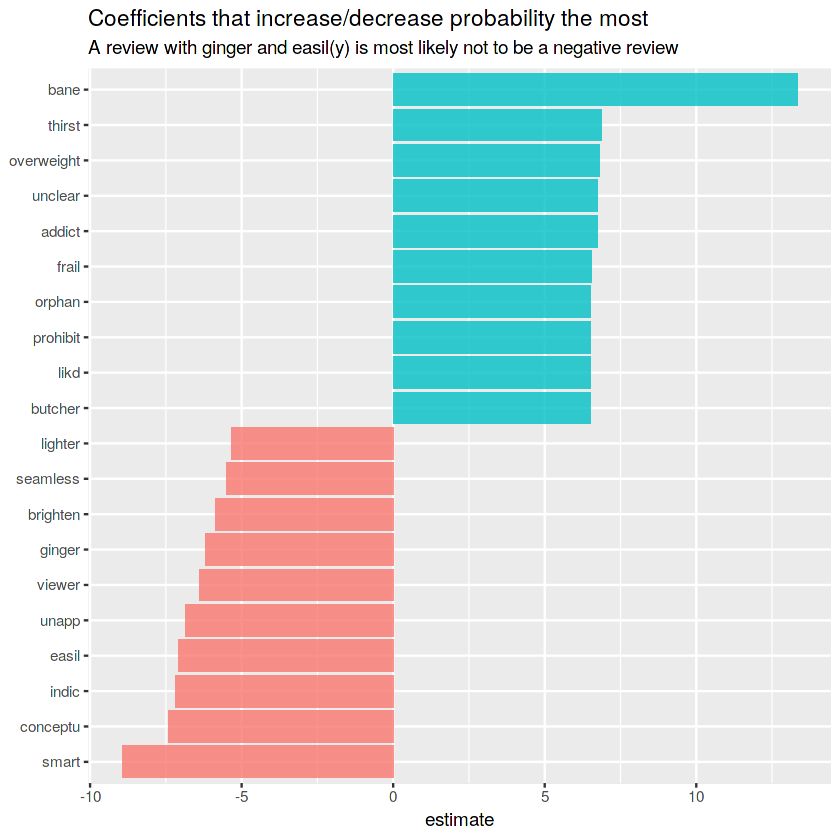

In [85]:
coefs %>%
  group_by(estimate > 0) %>%
  top_n(10, abs(estimate)) %>%
  ungroup() %>%
  ggplot(aes(fct_reorder(term, estimate), estimate, fill = estimate > 0)) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  coord_flip() +
  labs(
    x = NULL,
    title = "Coefficients that increase/decrease probability the most",
    subtitle = "A review with 'smart' and 'conceptu(el)'' is most likely not to be a negative review"
  )

So words as "bane" (cursed?), "overweight", orphan (bastard) and "uncler" have a positive effect for predicting a negative review, which make sence.

Same we can see some more positive words like "smart" and "easil(y)", which have a negative effect on predicting a negative review.

In [86]:
intercept <- coefs %>%
  filter(term == "(Intercept)") %>%
  pull(estimate)

classifications <- data_tidy %>%
  inner_join(test_data) %>%
  inner_join(coefs, by = c("word" = "term")) %>%
  group_by(X1) %>%
  summarize(score = sum(estimate)) %>%
  mutate(probability = plogis(intercept + score))

Joining, by = "X1"



In [89]:
comment_classes <- classifications %>%
  left_join(data_sent %>%
    select(Sentiment, X1), by = "X1") %>%
  mutate(Sentiment = as.factor(Sentiment))

I will check how the model predict the true classes by a confusion matrix as with the DL models. 

In [91]:
comment_classes %>%
  mutate(
    prediction = case_when(
      probability > 0.5 ~ "Negative",
      TRUE ~ "Positive"
    ),
    prediction = as.factor(prediction)
  ) %>%
  conf_mat(Sentiment, prediction)

          Truth
Prediction Negative Positive
  Negative      994       39
  Positive       61     3547

In [107]:
Sensivity = 994 / (994+61)
Sensivity

Specificity = 3547 / (3547+39)
Specificity

Accuracy = (994+3547) / (994+61+3547+39)
Accuracy

[1] 0.9421801

[1] 0.9891244

[1] 0.9784529

Well the model predict 97,8% correct - 94,2% true negative reviews and 98,91% true positive reviews. So a bit better than the LSTM model. 

Perhaps the reason is that I use the tidy dataset in this model, where I cleaned it for stop words, non alphanumeric characters and stemmed it, which I did not for the DL models (I only used keras tools). So this could maybe have improved the DP models, but I could not find time to figure this out (maybe I will try before the exam). 

# 5. Conclusion

Looking at the dataset "Women's E-Commerce Clothing Reviews" with around 20k reviews, I did some NLP and added the sentiment to the reviews, which I tried to predict using DP and a non-neural baseline model.

The **deep learning models** performed fine, where the LSTM model was the best one with a accuracy around 91% and predicting the under represented class, Negative reviews 69% correct.

The **non-neural baseline model** performed even better with a accuracy at 97,84%, where 94,2% of the negative reviews was predicted correct. The higher accuracy can probably be caused by more and better preprocessing if the tidy data, where the DP models only used preprocessing tools from keras.

Perhaps the **deep learning models** performance could have been improved by experimenting more with the architecture and tuning, but sadly I ran out of time + GPU Quota for kaggle (30 hrs) was used and first reset after the hand-in. 

Overall what could I use the results for? Well predicting the sentiment of reviews, look into negativ reviews and what words affect the sentiment, which can be used for companies to see what have a negative impact on their product reviews.

**Further development** could be to look deeper into what products and categories thathave the most negative reviews, divisions. Maybe also the reviews with high feedback counts, because this would probably be the most useful reviews.

# The end

![](https://www.askideas.com/media/35/Model-Walking-On-Ramp-In-Red-Weird-Dress-Funny-Picture.jpg)